# Saving and Loading Gluon Models

In reality you almost always save the models you train into files. There is a number of reasons to do this. For example,
1. You might want to do inference on a machine that is different from the one where the model was trained.
2. It is possible the model's performance on validation set decreased towards the end of the training for reasons like overfitting. If you saved your model parameters after every epoch, at the end you can decide to use the model that performs best on the vaidation set.

So, we need ways to save models to file and restore them back from file. In this tutorials we will learn ways to save and load Gluon models.

Let's start by importing the modules we'll need.

In [1]:
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import nd, autograd, gluon

import numpy as np

/home/ubuntu/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Build and train a simple model

We need a trained model before we can save it to a file. So let's go ahead and build a very simple convolutional network and train it on MNIST data.

In [14]:
# Use GPU if one exists, else use CPU
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

# MNIST images are 28x28. Total pixels in input layer is 28x28 = 784
num_inputs = 784
# Clasify the images into one of the 10 digits
num_outputs = 10
# 64 images in a batch
batch_size = 64

# Helper to preprocess data for training
def transform(data, label):
    return nd.transpose(data.astype(np.float32), (2,0,1))/255, label.astype(np.float32)

# Load the training data
train_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=True, transform=transform), 
                                   batch_size, shuffle=True)

# A helper method to train a given model using MNIST data
def train_model(model):

    # Initialize the parameters with Xavier initializer
    net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
    # Use cross entropy loss
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    # Use Adam optimizer
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .001})

    # Train for one epoch
    for epoch in range(1):
        # Iterate through the images and labels in the training data
        for batch_num, (data, label) in enumerate(train_data):
            # get the images and labels
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            # Ask autograd to record the forward pass
            with autograd.record():
                # Run the forward pass
                output = model(data)
                # Compute the loss
                loss = softmax_cross_entropy(output, label)
            # Compute gradients
            loss.backward()
            # Update parameters
            trainer.step(data.shape[0])

            # Print loss once in a while
            if batch_num % 50 == 0:
                curr_loss = nd.mean(loss).asscalar()
                print("Epoch: %d; Batch %d; Loss %f" % (epoch, batch_num, curr_loss))

# Build a simple convolutional network
def build_lenet(net):    
    with net.name_scope():
        # First convolution
        net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
        net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
        # Second convolution
        net.add(gluon.nn.Conv2D(channels=50, kernel_size=5, activation='relu'))
        net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
        # Flatten the output before the fully connected layers
        net.add(gluon.nn.Flatten())
        # First fully connected layers with 512 neurons
        net.add(gluon.nn.Dense(512, activation="relu"))
        # Second fully connected layer with as many neurons as the number of classes
        net.add(gluon.nn.Dense(num_outputs))
        
        return net

net = gluon.nn.Sequential()
net = build_lenet(net)
train_model(net)

/home/ubuntu/anaconda3/envs/dl/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:118: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  label = np.fromstring(fin.read(), dtype=np.uint8).astype(np.int32)
/home/ubuntu/anaconda3/envs/dl/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:122: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fin.read(), dtype=np.uint8)


Epoch: 0; Batch 0; Loss 2.307951
Epoch: 0; Batch 50; Loss 0.206552
Epoch: 0; Batch 100; Loss 0.226729
Epoch: 0; Batch 150; Loss 0.170944
Epoch: 0; Batch 200; Loss 0.147056
Epoch: 0; Batch 250; Loss 0.223776
Epoch: 0; Batch 300; Loss 0.159726
Epoch: 0; Batch 350; Loss 0.125166
Epoch: 0; Batch 400; Loss 0.115607
Epoch: 0; Batch 450; Loss 0.018448
Epoch: 0; Batch 500; Loss 0.043588
Epoch: 0; Batch 550; Loss 0.037301
Epoch: 0; Batch 600; Loss 0.101812
Epoch: 0; Batch 650; Loss 0.147746
Epoch: 0; Batch 700; Loss 0.161803
Epoch: 0; Batch 750; Loss 0.093747
Epoch: 0; Batch 800; Loss 0.110346
Epoch: 0; Batch 850; Loss 0.048226
Epoch: 0; Batch 900; Loss 0.012272


## Saving model parameters to file

Okay, we now have a model (`net`) that we can save to a file. Let's save the parameters of this model to a file.

In [3]:
file_name = "net.params"
net.save_params(file_name)

That's it! We have successfully saved the parameters of the model into a file.

## Loading model parameters from file

Let's now create a network with the parameters we saved into the file.

In [11]:
new_net = build_lenet()
new_net.load_params(file_name, ctx=ctx)

Let's test the model we just loaded from file.

/home/ubuntu/anaconda3/envs/dl/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:118: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  label = np.fromstring(fin.read(), dtype=np.uint8).astype(np.int32)
/home/ubuntu/anaconda3/envs/dl/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:122: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fin.read(), dtype=np.uint8)


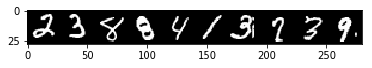

Model predictions:  [2. 3. 8. 8. 4. 1. 3. 7. 3. 9.]


In [12]:
import matplotlib.pyplot as plt

def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)

# Load ten random images from the test dataset
sample_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              10, shuffle=True)

for data, label in sample_data:

    # Display the images
    img = nd.transpose(data, (1,0,2,3))
    img = nd.reshape(img, (28,10*28,1))
    imtiles = nd.tile(img, (1,1,3))
    plt.imshow(imtiles.asnumpy())
    plt.show()

    # Display the predictions
    data = nd.transpose(data, (0, 3, 1, 2))
    out = new_net(data.as_in_context(ctx))
    predictions = nd.argmax(out, axis=1)
    print('Model predictions: ', predictions.asnumpy())

    break

## Saving model architecture and weights to file

Hybrid models can be serialized as JSON files using the `export` function. Once serialized, these models can be loaded from other language bindings like C++ or Scala for faster inference or inferences in different environments.

Note that the network we created above is not a Hybrid network and therefore cannot be serializes into a JSON file. So, let's create a Hybrid version of the same network and train it.

In [20]:
net = gluon.nn.HybridSequential()
net = build_lenet(net)
net.hybridize()
train_model(net)

Epoch: 0; Batch 0; Loss 2.308424
Epoch: 0; Batch 50; Loss 0.300352
Epoch: 0; Batch 100; Loss 0.221600
Epoch: 0; Batch 150; Loss 0.194225
Epoch: 0; Batch 200; Loss 0.135719
Epoch: 0; Batch 250; Loss 0.134151
Epoch: 0; Batch 300; Loss 0.221986
Epoch: 0; Batch 350; Loss 0.051619
Epoch: 0; Batch 400; Loss 0.031274
Epoch: 0; Batch 450; Loss 0.138601
Epoch: 0; Batch 500; Loss 0.024380
Epoch: 0; Batch 550; Loss 0.045157
Epoch: 0; Batch 600; Loss 0.035302
Epoch: 0; Batch 650; Loss 0.063703
Epoch: 0; Batch 700; Loss 0.062556
Epoch: 0; Batch 750; Loss 0.265665
Epoch: 0; Batch 800; Loss 0.040130
Epoch: 0; Batch 850; Loss 0.020004
Epoch: 0; Batch 900; Loss 0.173895


In [21]:
net.export("lenet", epoch=1)

That's it! `export` in this case creates `lenet-symbol.json` and `lenet-0001.params` in the current directory.

## Loading model architecture and weights from a different frontend

Primary reason to serialize model architecture into a JSON file is to load it from a different frontend like C, C++ or Scala. Here is a couple of examples:
1. [Loading serialized Hybrid networks from C](https://github.com/apache/incubator-mxnet/blob/master/example/image-classification/predict-cpp/image-classification-predict.cc)
2. [Loading serialized Hybrid networks from Scala](https://github.com/apache/incubator-mxnet/blob/master/scala-package/infer/src/main/scala/org/apache/mxnet/infer/ImageClassifier.scala)

## Loading model architecture from Python

Serialized Hybrid networks (saved as .JSON and .params file) can be loaded and used inside Python frontend using `mx.model.load_checkpoint` and `gluon.nn.SymbolBlock`. To demonstrate that, let's load the network we serialized above.

In [34]:
# Load the network architecture and parameters
sym, arg_params, aux_params = mx.model.load_checkpoint('lenet', 1)
# Create a Gluon Block using the loaded network architecture
deserialized_net = gluon.nn.SymbolBlock(outputs=sym, inputs=mx.sym.var('data'))
# Set the parameters
net_params = deserialized_net.collect_params()
for param in arg_params:
    if param in net_params:
        net_params[param]._load_init(arg_params[param], ctx=ctx)
for param in aux_params:
    if param in net_params:
        net_params[param]._load_init(aux_params[param], ctx=ctx)

Let's test the deserialized network to make sure it works.

/home/ubuntu/anaconda3/envs/dl/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:118: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  label = np.fromstring(fin.read(), dtype=np.uint8).astype(np.int32)
/home/ubuntu/anaconda3/envs/dl/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:122: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fin.read(), dtype=np.uint8)


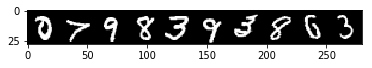

Model predictions:  [0. 7. 9. 8. 3. 9. 3. 8. 6. 3.]


In [35]:
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)

# Load ten random images from the test dataset
sample_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              10, shuffle=True)

for data, label in sample_data:

    # Display the images
    img = nd.transpose(data, (1,0,2,3))
    img = nd.reshape(img, (28,10*28,1))
    imtiles = nd.tile(img, (1,1,3))
    plt.imshow(imtiles.asnumpy())
    plt.show()

    # Display the predictions
    data = nd.transpose(data, (0, 3, 1, 2))
    out = deserialized_net(data.as_in_context(ctx))
    predictions = nd.argmax(out, axis=1)
    print('Model predictions: ', predictions.asnumpy())

    break